---
title: "PatentsView Project"
author: "Shania Braithwaite"
format: html
toc: true
number-sections: true
theme: journal
---


In [115]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import json

In [2]:
import duckdb
con = duckdb.connect("patentsview.ddb")

In [3]:
con.read_csv("g_patent.tsv", all_varchar= True).create("g_patent")

CatalogException: Catalog Error: Table with name "g_patent" already exists!

In [ ]:
con.read_csv("g_location_not_disambiguated.tsv", all_varchar= True).create("g_location_not_disambiguated")

In [ ]:
con.read_csv("g_assignee_not_disambiguated.tsv", all_varchar= True).create("g_assignee_not_disambiguated")

In [5]:
con.read_csv("g_ipc_at_issue.tsv", all_varchar= True).create("g_ipc_at_issue")

CatalogException: Catalog Error: Table with name "g_ipc_at_issue" already exists!

In [47]:
g_patent= con.table("g_patent")
g_location_not_disambiguated= con.table("g_location_not_disambiguated")
g_assignee_not_disambiguated= con.table("g_assignee_not_disambiguated")
g_ipc_at_issue= con.table("g_ipc_at_issue")

In [9]:
assignee_location= g_assignee_not_disambiguated.join(g_location_not_disambiguated, "rawlocation_id", how = "left")

In [11]:
assignee_location_patent= assignee_location.join(g_patent, "patent_id", how = "left")

In [12]:
assignee_location_patent_ipc= assignee_location_patent.join(g_ipc_at_issue, "patent_id", how = "left")

In [15]:
assignee_location_patent_ipc.limit(5).df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,8706653,0,0e2ac780-362c-426b-a7d9-5dff223f6690,None,None,Microsoft Corporation,2,048t5o3s1cd7lbfeym8fs5upo,816d1200-16c8-11ed-9b5f-1234bde3cd05,Redmond,...,G,06,F,15,18,I,B,H,2014-04-22,2006-01-01
1,9235793,0,478d7ac9-d36b-445e-8604-856ddf7ccbd3,None,None,"RICOH COMPANY, LTD.",3,048tayjhrut0xmr7ocptmtiz9,42f90495-16c8-11ed-9b5f-1234bde3cd05,Tokyo,...,G,03,G,15,00,I,B,H,2016-01-12,2006-01-01
2,10693352,0,7960df4e-6fe5-408c-9aeb-b380b10cf6bf,None,None,GE Energy Power Conversion Technology LTD.,3,048tdq4305km2a81q6zorxogt,4ca94c26-16c8-11ed-9b5f-1234bde3cd05,Warwickshire,...,H,2,K,15,2,I,B,H,2020-06-23,2006-01-01
3,11207590,0,b59b7385-fefc-4f4f-9316-0d55455596d4,None,None,Performance Designed Products LLC,2,048tjx1mn9f8wdkoa0rt4mqtc,1893009c-16c8-11ed-9b5f-1234bde3cd05,San Diego,...,A,63,F,13,235,I,B,H,2021-12-28,2014-01-01
4,6604345,0,6e0b637a-094c-4842-bc4b-82d7978a364e,None,None,Sollas Holland B.V.,3,048tptdhtdc68ihyrkecz5dj7,7dda59ae-16c8-11ed-9b5f-1234bde3cd05,Wormer,...,B,65,B,13,04,None,None,None,None,None


In [27]:
column_names = [desc[0] for desc in con.execute("SELECT * FROM assignee_location_patent_ipc").description]

# Print column names
print("Column Names:", column_names)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Column Names: ['patent_id', 'assignee_sequence', 'assignee_id', 'raw_assignee_individual_name_first', 'raw_assignee_individual_name_last', 'raw_assignee_organization', 'assignee_type', 'rawlocation_id', 'location_id', 'raw_city', 'raw_state', 'raw_country', 'patent_type', 'patent_date', 'patent_title', 'wipo_kind', 'num_claims', 'withdrawn', 'filename', 'ipc_sequence', 'classification_level', 'section', 'ipc_class', 'subclass', 'main_group', 'subgroup', 'classification_value', 'classification_status', 'classification_data_source', 'action_date', 'ipc_version_indicator']


In [35]:
len(assignee_location_patent_ipc)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

23626300

In [17]:
# Define the biotechnology IPC sections, classes, and subclasses
biotech_ipc_sections = ['C']  # 'C' stands for Chemistry (relevant for biotech)
biotech_ipc_classes = ['07', '12']  # Classes '07' (Organic Chemistry) and '12' (Biochemistry)
biotech_ipc_subclasses = ['G', 'M', 'N', 'P', 'Q', 'R', 'S']  # Relevant subclasses for biotechnology

In [49]:
# SQL query to filter for biotechnology-related patents
query_biotech = f"""
SELECT *
FROM assignee_location_patent_ipc 
WHERE section IN ({', '.join([f"'{section}'" for section in biotech_ipc_sections])})
  AND ipc_class IN ({', '.join([f"'{ipc_class}'" for ipc_class in biotech_ipc_classes])})
  AND subclass IN ({', '.join([f"'{subclass}'" for subclass in biotech_ipc_subclasses])})
"""
biotech_data = con.execute(query_biotech).fetchdf()

#print(biotech_data.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [51]:
len(biotech_data) 

409255

In [53]:
# Display the DataFrame neatly
display(biotech_data.head())

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,10273482,0,29a4c36c-e0ef-45d5-bc08-749ac02719ff,None,None,"Arrowhead Pharmaceuticals, Inc.",2,0l9zphrvh2doiqnhy2y7c02xr,198b2267-16c8-11ed-9b5f-1234bde3cd05,Pasadena,...,C,12,N,15,113,I,B,H,2019-04-30,2010-01-01
1,8877918,0,602209ed-b174-4f1a-9040-5d7de7e5af9f,None,None,Tokyo University of Agriculture and Technology,3,0lad3bx4wakbitcr089ler2mk,42f90495-16c8-11ed-9b5f-1234bde3cd05,Tokyo,...,C,12,N,15,10,I,B,H,2014-11-04,2006-01-01
2,8008065,0,f30cf4a7-517f-4780-87fa-c46373787f45,None,None,"Finesse Solutions, LLC.",2,0law37bkz2flkf4ckgyf11gsi,13f05eea-16c8-11ed-9b5f-1234bde3cd05,San Jose,...,C,12,M,1,26,I,B,H,2011-08-30,2006-01-01
3,9237717,0,8c6a0534-0e3a-44c7-b94f-986e49168c6f,None,None,M.S. Technologies LLC,2,0lazmc4auia8d2fmq4u4c35en,ce7f399c-16c7-11ed-9b5f-1234bde3cd05,West Point,...,C,12,N,15,82,I,B,H,2016-01-19,2006-01-01
4,10961387,0,33df1f63-9653-48a1-b495-70deb319ad64,None,None,EGGPLANT S.R.L.,3,0lb40ve2wrdneq298woyasx2i,9af34c1c-16c8-11ed-9b5f-1234bde3cd05,Polignano A Mare,...,C,12,P,7,62,I,B,H,2021-03-30,2006-01-01


In [74]:
country_US = ['US']

# SQL query to filter for biotechnology-related patents in the US
query_biotech_US = """
SELECT patent_title, raw_state, raw_country, ipc_class, subclass, main_group, section, assignee_type
FROM assignee_location_patent_ipc 
WHERE section IN ?
  AND ipc_class IN ?
  AND subclass IN ?
  AND raw_country IN ?
"""

# Execute the query and fetch the results as a DataFrame
biotech_data_US = con.execute(query_biotech_US, [biotech_ipc_sections, biotech_ipc_classes, biotech_ipc_subclasses, country_US]).fetchdf()

# Print the DataFrame
display(biotech_data_US.head())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_title,raw_state,raw_country,ipc_class,subclass,main_group,section,assignee_type
0,Humanized universal light chain mice,NY,US,12,N,5,C,2
1,Use of Xylella fastidiosa strain EB92-1 to gen...,FL,US,12,N,1,C,2
2,Medical device for analyte monitoring and drug...,CA,US,12,M,3,C,2
3,Methods of treating cancer with atovaquone-rel...,MA,US,12,Q,1,C,2
4,"Method for diagnosing, preventing, and treatin...",DC,US,12,Q,1,C,2


In [96]:
country_US = ['US']

# SQL query to filter for biotechnology-related patents in the US
query_biotech_US = """
SELECT *
FROM assignee_location_patent_ipc 
WHERE section IN ?
  AND ipc_class IN ?
  AND subclass IN ?
  AND raw_country IN ?
"""

# Execute the query and fetch the results as a DataFrame
biotech_data_US = con.execute(query_biotech_US, [biotech_ipc_sections, biotech_ipc_classes, biotech_ipc_subclasses, country_US]).fetchdf()

# Print the DataFrame
display(biotech_data_US.head())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,patent_id,assignee_sequence,assignee_id,raw_assignee_individual_name_first,raw_assignee_individual_name_last,raw_assignee_organization,assignee_type,rawlocation_id,location_id,raw_city,...,section,ipc_class,subclass,main_group,subgroup,classification_value,classification_status,classification_data_source,action_date,ipc_version_indicator
0,11046635,0,dfa48322-8ffd-4440-b218-e7f7b4885f6a,None,None,"GENOMATICA, INC.",2,9hrqrfqktxfnjldy84mmxlhjr,1893009c-16c8-11ed-9b5f-1234bde3cd05,San Diego,...,C,12,N,1,14,I,B,H,2021-06-29,2006-01-01
1,11046721,0,541d21ab-6f07-4201-98d6-c911976a0dea,None,None,The Trustees of the University of Pennsylvania,2,35s27t26dgw9hp3zbhynvpoz0,8a6e68e9-16c8-11ed-9b5f-1234bde3cd05,Philadelphia,...,C,12,Q,1,6818,I,B,H,2021-06-29,2018-01-01
2,11046726,0,195d7409-d1de-49c7-91a6-efd85589e9be,None,None,"QIAGEN SCIENCES, LLC",2,c9v07b8y9u1qzmntelbwsl7i3,005d7675-16c8-11ed-9b5f-1234bde3cd05,Germantown,...,C,12,Q,1,6811,I,B,H,2021-06-29,2018-01-01
3,11046727,0,27deb5cd-8522-47d8-8052-b61c4f335746,None,None,Life Technologies Corporation,2,ww5w569fmrvoztcnro2pljd7t,c6c6afd0-16c7-11ed-9b5f-1234bde3cd05,Carlsbad,...,C,12,Q,1,6876,I,B,H,2021-06-29,2018-01-01
4,11046735,0,48c86698-a552-43d7-8982-3d1508ce6533,None,None,Spogen Biotech Inc.,2,yje7i36p5qn5v27stnxyaua8h,8bf5b0c0-16c8-11ed-9b5f-1234bde3cd05,St. Louis,...,C,12,P,21,2,I,B,H,2021-06-29,2006-01-01


In [76]:
len(biotech_data_US)

242577

In [92]:
# Register the filtered data as a DuckDB table
con.register('filtered_biotech_data_US', biotech_data_US)

In [110]:
# Query to extract year from patent_date and count patents per year and state
query = """
SELECT 
    EXTRACT(YEAR FROM CAST(patent_date AS DATE)) AS year,
    raw_state,
    COUNT(*) AS patent_count
FROM biotech_data_US 
GROUP BY year, raw_state
ORDER BY year ASC, raw_state
"""

# Execute the query and fetch results
patent_trends_by_state = con.execute(query).fetchdf()

display(patent_trends_by_state.head())

,year,raw_state,patent_count
0,1976,AZ,4
1,1976,CA,7
2,1976,CT,1
3,1976,DC,6
4,1976,DE,1


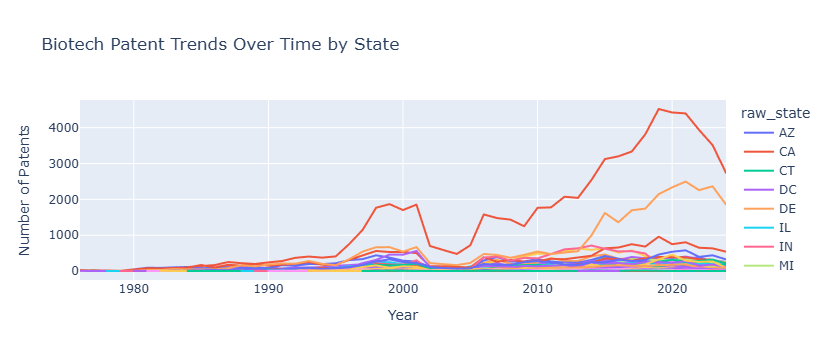

In [112]:
# Create an interactive line plot showing patent trends by state
fig = px.line(
    patent_trends_by_state, 
    x="year", 
    y="patent_count", 
    color="raw_state",  # Color by state
    title="Biotech Patent Trends Over Time by State",
    labels={"patent_count": "Number of Patents", "year": "Year"}
)

# Show the plot
fig.show()


In [114]:
# Group by assignee_type and count patents
query_grouped = """
SELECT 
    assignee_type,
    COUNT(*) AS patent_count,
FROM filtered_biotech_data_US
GROUP BY assignee_type
ORDER BY patent_count DESC
"""

# Execute the query and fetch the grouped data as a DataFrame
grouped_biotech_data_US = con.execute(query_grouped).fetchdf()

# Print the grouped data
display(grouped_biotech_data_US)

,assignee_type,patent_count
0,2,235199
1,6,6178
2,4,835
3,9,162
4,3,160
5,12,15
6,5,9
7,14,8
8,8,6
9,None,2


In [116]:
result = con.execute("DESCRIBE filtered_biotech_data_US").fetchall()

# Print column names
column_names = [row[0] for row in result]
print("Column names:", column_names)

Column names: ['patent_title', 'raw_state', 'raw_country', 'ipc_class', 'subclass', 'main_group', 'section', 'assignee_type']


In [88]:
con.register('grouped_biotech_data_US', grouped_biotech_data_US)


C:\Users\shani\AppData\Local\Temp\ipykernel_20324\2655852703.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




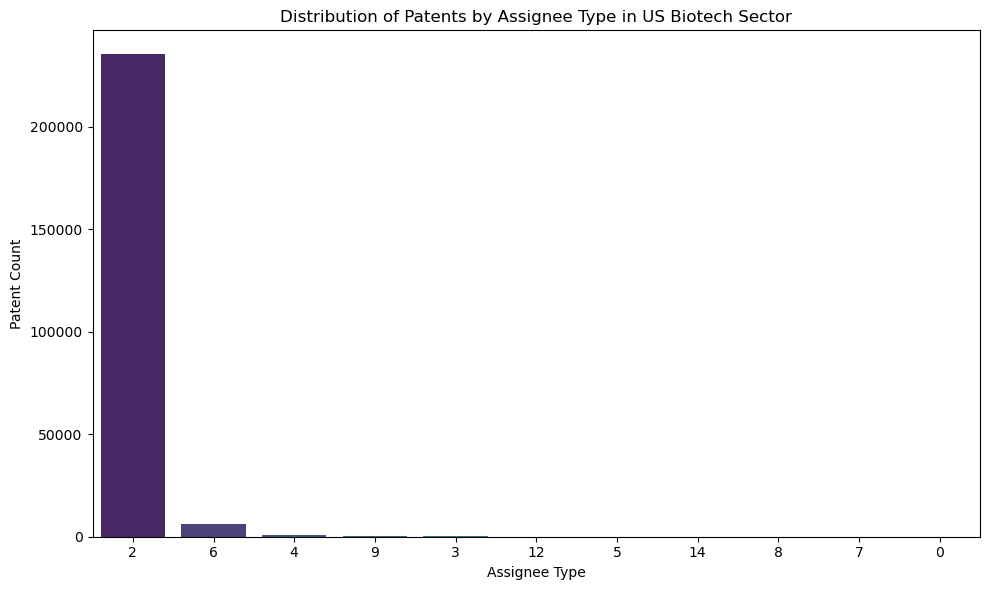

In [120]:
plt.figure(figsize=(10, 6))
sns.barplot(x='assignee_type', y='patent_count', data=grouped_biotech_data_US, palette='viridis')

# Add labels and title
plt.xlabel('Assignee Type')
plt.ylabel('Patent Count')
plt.title('Distribution of Patents by Assignee Type in US Biotech Sector')

# Show the plot
plt.tight_layout()
plt.show()

In [124]:
# Filter the data for the most common assignee type (e.g., 'US company' or 'corporation')
common_assignee_type = '2' 
query_filtered = f"""
SELECT *
FROM filtered_biotech_data_US
WHERE assignee_type = '{common_assignee_type}'
"""

# Execute the query to get the filtered data
filtered_assignee_data = con.execute(query_filtered).fetchdf()


In [126]:
# Group by 'raw_state' to get the distribution by state
query_geographic_distribution = """
SELECT raw_state, COUNT(*) AS patent_count
FROM filtered_assignee_data
GROUP BY raw_state
ORDER BY patent_count DESC
"""

# Execute the query to get the grouped data
geographic_data = con.execute(query_geographic_distribution).fetchdf()

# Print the geographic data
display(geographic_data)


,raw_state,patent_count
0,CA,67615
1,MA,30684
2,NY,15678
3,NJ,10175
4,MO,8820
5,IA,8443
6,PA,7677
7,MD,7240
8,IL,6530
9,TX,6193


In [158]:
# Read the shapefile (adjust with the path to your shapefile)
us_map = gpd.read_file("ne_110m_admin_1_states_provinces.shp")


#print(us_map['name'].unique())

In [130]:
state_abbreviation_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

In [132]:
# Convert state abbreviations in DuckDB data to full state names
geographic_data['full_state_name'] = geographic_data['raw_state'].map(state_abbreviation_to_name)

# Check the result to confirm the mapping
print(geographic_data[['raw_state', 'full_state_name']].head())

  raw_state full_state_name
0        CA      California
1        MA   Massachusetts
2        NY        New York
3        NJ      New Jersey
4        MO        Missouri


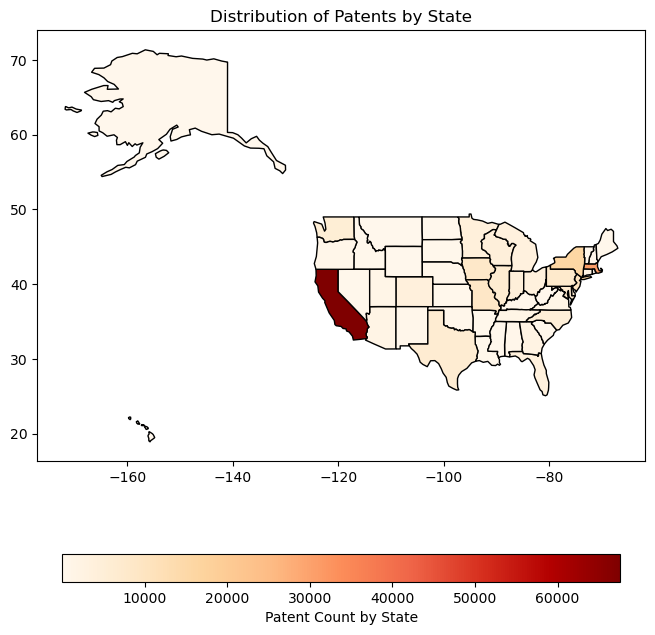

In [134]:
#Merge the shapefile with the DuckDB data based on full state names
merged = us_map.set_index('name').join(geographic_data.set_index('full_state_name'))

# Check the result of the merge
#print(merged.head())

# Plot the map with the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with 'patent_count' for each state
merged.plot(
    column='patent_count', 
    ax=ax,
    legend=True,
    edgecolor='black',  # Add borders
    cmap='OrRd',  # Color palette: Orange-Red
    legend_kwds={
        'label': "Patent Count by State",
        'orientation': "horizontal",
        'shrink': 0.6  # Adjust legend size
    }
)

# Set the title
plt.title(f'Distribution of Patents by State')

# Show the map
plt.show()

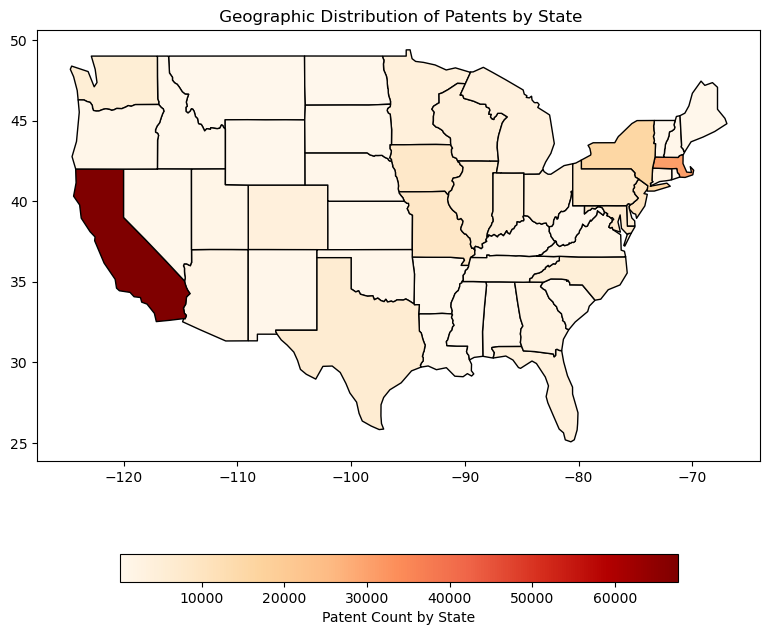

In [136]:
#Removing Alaska
geographic_data = geographic_data[~geographic_data['raw_state'].isin(['AK', 'HI'])]

#Merge the shapefile with the DuckDB data based on full state names
merged = us_map.set_index('name').join(geographic_data.set_index('full_state_name'))

# Check the result of the merge
#print(merged.head())

# Plot the map with the merged data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the map with 'patent_count' for each state
merged.plot(
    column='patent_count',  # Column for color shading
    ax=ax,
    legend=True,
    edgecolor='black',  # Add borders
    cmap='OrRd',  # Color palette: Orange-Red
    legend_kwds={
        'label': "Patent Count by State",
        'orientation': "horizontal",
        'shrink': 0.6  # Adjust legend size
    }
)

# Set the title
plt.title(f' Geographic Distribution of Patents by State')

# Show the map
plt.show()

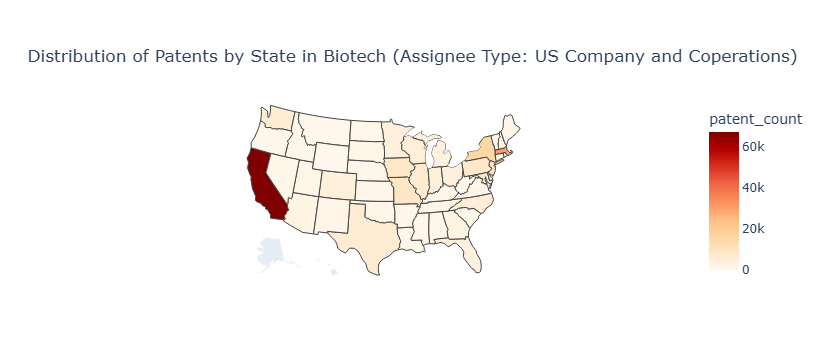

In [154]:
# Ensure geographic_data contains the necessary columns: Raw state, assignee type, and patent count
geographic_data['full_state_name'] = geographic_data['raw_state']



# Interactive choropleth map
fig = px.choropleth(
    geographic_data,
    locations="raw_state",  # Full state names in the data
    locationmode="USA-states",  # Map to US states
    color="patent_count",  # Column to define the color scale
    hover_name="raw_state",  # Column for state name in hover
    color_continuous_scale="OrRd",  # Color scale
    scope="usa",  # Focus on the USA map
    title=f"Distribution of Patents by State (Assignee Type: {common_assignee_type})"
)

# Customize layout
fig.update_layout(
    title={
        "text": f"Distribution of Patents by State in Biotech (Assignee Type: US Company and Coperations)",
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top"
    },
    geo=dict(
        lakecolor="rgb(255, 255, 255)"  # Make lakes white
    )
)

# Show map
fig.show()

In [140]:
'''# Check the state mapping
print(geographic_data[['raw_state', 'full_state_name', 'patent_count']].head())
print(geographic_data['full_state_name'].isnull().sum())

# Check merged data (if you use the merged dataset for Plotly)
print(merged.head())
print(merged.isnull().sum())
'''

"# Check the state mapping\nprint(geographic_data[['raw_state', 'full_state_name', 'patent_count']].head())\nprint(geographic_data['full_state_name'].isnull().sum())\n\n# Check merged data (if you use the merged dataset for Plotly)\nprint(merged.head())\nprint(merged.isnull().sum())\n"

In [142]:
con.read_csv("state_population.csv", all_varchar= True).create("state_pop")

CatalogException: Catalog Error: Table with name "state_pop" already exists!

In [144]:
#con.execute("DROP TABLE IF EXISTS state_pop")

In [146]:
state_pop= con.table("state_pop")

In [164]:
state_pop.limit(5).df()

,raw_state,population
0,Alabama,"5,157,699"
1,Alaska,"740,133"
2,Arizona,"7,582,384"
3,Arkansas,"3,088,354"
4,California,"39,431,263"


In [166]:
#con.execute("DROP VIEW IF EXISTS state_pop1")


In [168]:
geographic_data['full_state_name'] = geographic_data['raw_state'].map(state_abbreviation_to_name)


query_patent_density = """
SELECT 
    g.full_state_name,  -- Using full state name for the join
    g.patent_count, 
    p.population AS population,
    ROUND((CAST(g.patent_count AS FLOAT) * 100000.0) / CAST(REPLACE(p.population, ',', '') AS FLOAT), 2) AS patent_density  -- Remove commas and cast to FLOAT
FROM geographic_data g
JOIN state_pop p
ON g.full_state_name = p.raw_state  -- Matching full state name
ORDER BY patent_density DESC
"""

patent_density_data = con.execute(query_patent_density).fetchdf()

display(patent_density_data)



,full_state_name,patent_count,population,patent_density
0,Delaware,5926,"1,051,917",563.349976
1,Massachusetts,30684,"7,136,171",429.980011
2,Iowa,8443,"3,241,488",260.470001
3,California,67615,"39,431,263",171.479996
4,Missouri,8820,"6,245,466",141.220001
5,Maryland,7240,"6,263,220",115.599998
6,New Jersey,10175,"9,500,851",107.099998
7,New York,15678,"19,867,248",78.910004
8,Wisconsin,4469,"5,960,975",74.970001
9,Minnesota,4044,"5,793,151",69.809998


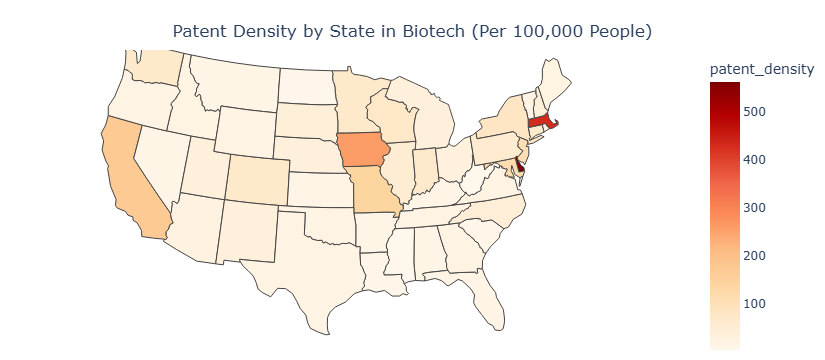

In [170]:
# Merge the shapefile data with patent density data
merged_data = us_map.set_index('name').join(patent_density_data.set_index('full_state_name'))


fig = px.choropleth(
    merged_data,
    geojson=merged_data.geometry,
    locations=merged_data.index,
    color="patent_density",  
    hover_name=merged_data.index,  
    hover_data={
        "patent_density": True,
        "patent_count": True,
        "population": True,
    },
    color_continuous_scale="OrRd",  
    title="Patent Density by State in Biotech (Per 100,000 People)",
)

fig.update_geos(
    visible=False,
    fitbounds="locations",
    projection=dict(type="albers usa"),  
    lakecolor="rgb(255, 255, 255)"  
)

fig.update_layout(
    title={
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top"
    },
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
)

fig.show()

In [786]:
""" 
# Ensure full state names are converted to abbreviations
patent_density_data['state_abbreviation'] = patent_density_data['full_state_name'].map(
    {v: k for k, v in state_abbreviation_to_name.items()}
)

# Interactive choropleth map showing patent density per 100,000 people
fig = px.choropleth(
    patent_density_data,
    locations="state_abbreviation",  # Use state abbreviations here
    locationmode="USA-states",  # Correct mode for state abbreviations
    color="patent_density",  # Column to define the color scale
    hover_name="full_state_name",  # Full state names in hover
    color_continuous_scale="OrRd",  # Color scale for density
    scope="usa",  # Focus on the USA map
    title="Patent Density per 100,000 People by State in Biotech Sector"
)

# Customize layout
fig.update_layout(
    title={
        "text": "Patent Density per 100,000 People by State in Biotech Sector",
        "x": 0.5,  # Center title
        "xanchor": "center",
        "yanchor": "top"
    },
    geo=dict(
        lakecolor="rgb(255, 255, 255)"  # Make lakes white
    )
)

# Show map
fig.show()
"""


' \n# Ensure full state names are converted to abbreviations\npatent_density_data[\'state_abbreviation\'] = patent_density_data[\'full_state_name\'].map(\n    {v: k for k, v in state_abbreviation_to_name.items()}\n)\n\n# Interactive choropleth map showing patent density per 100,000 people\nfig = px.choropleth(\n    patent_density_data,\n    locations="state_abbreviation",  # Use state abbreviations here\n    locationmode="USA-states",  # Correct mode for state abbreviations\n    color="patent_density",  # Column to define the color scale\n    hover_name="full_state_name",  # Full state names in hover\n    color_continuous_scale="OrRd",  # Color scale for density\n    scope="usa",  # Focus on the USA map\n    title="Patent Density per 100,000 People by State in Biotech Sector"\n)\n\n# Customize layout\nfig.update_layout(\n    title={\n        "text": "Patent Density per 100,000 People by State in Biotech Sector",\n        "x": 0.5,  # Center title\n        "xanchor": "center",\n        